In [1]:
#%%
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
import seaborn as sns

def setstyle(stylename):
    sns.set()
    sns.set_style(stylename, {'font.family': 'serif'})
    sns.set_context('paper',font_scale=0.9)

def savefig(fig,fn,width_inches,height_inches):
    fig.set_size_inches(width_inches, height_inches)
    try:
        plt.tight_layout()
    except:
        pass
    fig.savefig('{}.png'.format(fn),dpi=600)
    fig.savefig('{}.pdf'.format(fn))
    fig.savefig('{}.svg'.format(fn))
    return fig

IEEE_2COL = 7.16 # IEEE \textwidth in inches
IEEE_1COL = 3.5 # IEEE \columnwidth in inches

def makecross(x,y):
    l=0.5
    ax.plot([x-l,x+l],[y,y],color='k',linewidth=1)
    ax.plot([x,x],[y-l,y+l],color='k',linewidth=1)

In [3]:
with open('icra2020_complete_anonymized.pkl', 'rb') as f:
    d = pickle.load(f,encoding='latin1')
color = dict(JOYSTICK=(0.3,0.5,0.7), POINTING=(0.1,0.4,0.1))

data = d['data']
moves = d['moves']
targets = d['targets']
shapes = d['shapes']

strange session with id 34 target 1 interface JOYSTICK
DISCARDING
strange session with id 34 target 2 interface JOYSTICK
DISCARDING
strange session with id 35 target 1 interface JOYSTICK
DISCARDING
strange session with id 35 target 2 interface JOYSTICK
DISCARDING
strange session with id 36 target 3 interface JOYSTICK
DISCARDING
strange session with id 76 target 1 interface JOYSTICK
DISCARDING
strange session with id 17 target 3 interface POINTING
DISCARDING
strange session with id 69 target 1 interface POINTING
DISCARDING
strange session with id 69 target 2 interface POINTING
DISCARDING
strange session with id 86 target 2 interface POINTING
DISCARDING


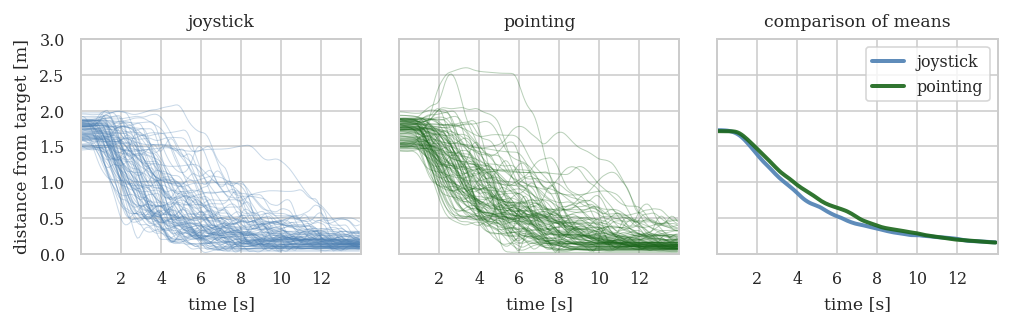

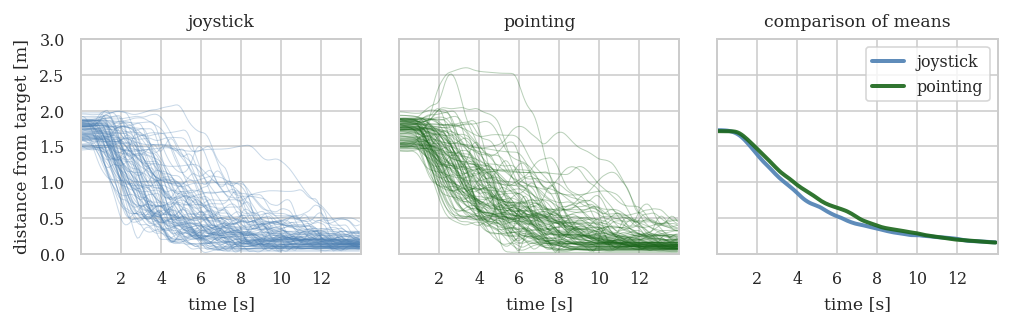

In [4]:
#%% Analyze distance to target

def dist_to_target_3d(xyz,t0,target_x,target_y,target_z,resample_t):
    dist=np.linalg.norm(xyz.values-np.array([[target_x,target_y,target_z]]),axis=1)
    dist_t=(xyz.index-t0)/pd.Timedelta("1s")
    return np.interp(resample_t, dist_t, dist)

t0,t1 = 0,14
t=np.arange(t0,t1,0.1)

setstyle('whitegrid')
fig,axs=plt.subplots(ncols=3,sharex=True,sharey=True)
handles=dict()
count = 0
for ax,interface in zip(axs,['JOYSTICK','POINTING']):
    c=color[interface]
    dists=[]
    for _,m in moves[moves['interface']==interface].iterrows():
        target = targets.loc[m.target]
        p = data.loc[m.t0:m.t1]
        p = p.set_index(p.index.tz_localize(None))
        dist=dist_to_target_3d(
            p.loc[:,['gt_x','gt_y','gt_z']],
            m.t0,  
            target.x, target.y, target.z, t)
        if(dist[-1]) > 0.5: 
            print(f'strange session with id {m.session_id} target {m.target} interface {m.interface}')
            print('DISCARDING')
            continue
        count+=1
        ax.plot(t,dist,color=c,alpha=0.3,linewidth=0.5)
        # ax.axvline(x=(m.t1-m.t0)/pd.Timedelta("1s"),color=c,alpha=0.3,linewidth=0.5)
        dists.append(dist)
    handles[interface] = axs[2].plot(
        t,np.mean(np.array(dists),axis=0),color=c,alpha=0.9,linewidth=2,linestyle="-")
    ax.set(title=interface.lower(),
           xlim=[t0,t1], ylim=[0.0, 3.0])
           
for ax in axs:
    ax.set(xlabel='time [s]')
    from matplotlib.ticker import MaxNLocator
    #ax.xaxis.set_major_locator(MaxNLocator(prune='both'))
    ax.set_xticks(np.arange(2,14,2))
    ax.set_yticks(np.arange(0,3.5,0.5))
    
axs[0].set(ylabel='distance from target [m]')
axs[2].set(title='comparison of means')
axs[2].legend([h[0] for l,h in handles.items()],
              [l.lower() for l,h in handles.items()],
              loc='upper right')

savefig(fig, 'disttotarget', IEEE_2COL, 2.34)


In [5]:
def f(m):
    target = targets.loc[m.target].values
    xyz = data.loc[m.t0:m.t1,['gt_x','gt_y','gt_z']].values
    p0 = xyz[0,:]
    mindist = np.linalg.norm(target-p0)
    xyzdiff = np.diff(xyz, axis=0)
    segdists = np.hypot(xyzdiff[:,0], xyzdiff[:,1])
    dist = np.sum(segdists)
    return dist/mindist

moves['rel_length'] = moves.apply(f,axis=1)
moves['duration_s'] = moves.duration / pd.Timedelta('1s')

In [6]:
def f(m):
    xyz = data.loc[m.t0:m.t1,['gt_x','gt_y','gt_z']].values
    p0 = xyz[[0],:]
    return targets.index[np.argmin(np.linalg.norm(targets.values-p0, axis=1))]

moves['source'] = moves.apply(f,axis=1)

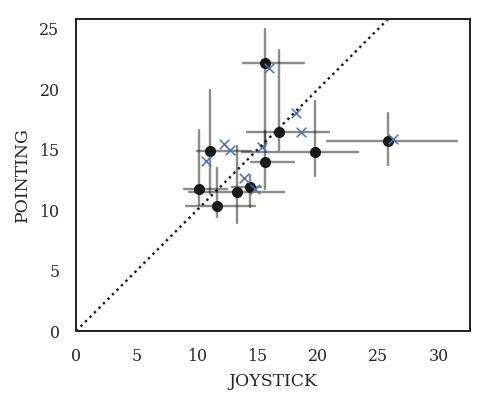

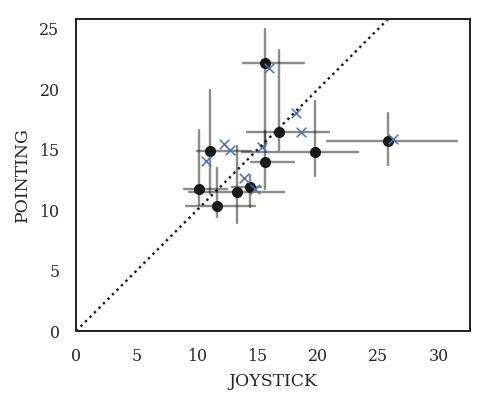

In [7]:
# Time to target plot

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_

d = moves.groupby(['user_id', 'interface'])[
    'duration_s'].agg(['median','mean','std',percentile(25),percentile(75)]).unstack()

setstyle('white')
fig, ax = plt.subplots()

sns.scatterplot(data=d['median'],
                x='JOYSTICK', y='POINTING', ax=ax, color='k',
                edgecolor=None, zorder=2)
plt.plot(np.array([d['p_25']['JOYSTICK'], d['p_75']['JOYSTICK']]),
         np.array([d['median']['POINTING'], d['median']['POINTING']]),
         '-k', alpha=0.5, zorder=1)
plt.plot(np.array([d['median']['JOYSTICK'], d['median']['JOYSTICK']]),
         np.array([d['p_25']['POINTING'], d['p_75']['POINTING']]),
         '-k', alpha=0.5, zorder=1)

sns.scatterplot(data=d['mean'],
                x='JOYSTICK', y='POINTING', ax=ax, color='b', marker='x', zorder=2)

#sns.scatterplot(data=d,
#                x='JOYSTICK', y='POINTING', ax=ax)
M = max(ax.get_xlim()+ax.get_ylim())
ax.autoscale(False)
ax.plot([0, M],[0, M],':k')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_aspect('equal')
savefig(fig, 'users_duration', IEEE_1COL, 3)

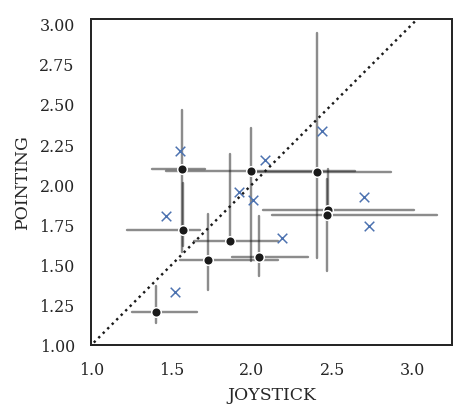

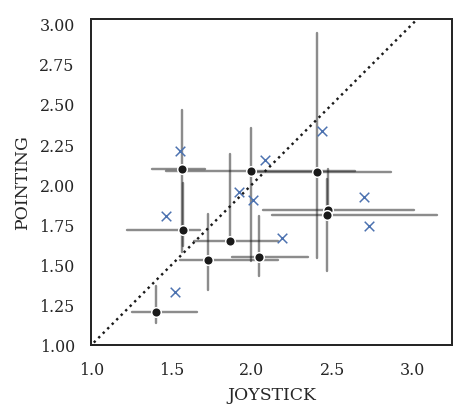

In [8]:
# Relative path length plot

d = moves.groupby(['user_id', 'interface'])[
    'rel_length'].agg(['median','mean','std',percentile(25),percentile(75)]).unstack()

setstyle('white')
fig, ax = plt.subplots()

sns.scatterplot(data=d['median'],
                x='JOYSTICK', y='POINTING', ax=ax, color='k', zorder=2)
plt.plot(np.array([d['p_25']['JOYSTICK'], d['p_75']['JOYSTICK']]),
         np.array([d['median']['POINTING'], d['median']['POINTING']]),
         '-k', alpha=0.5, zorder=1)
plt.plot(np.array([d['median']['JOYSTICK'], d['median']['JOYSTICK']]),
         np.array([d['p_25']['POINTING'], d['p_75']['POINTING']]),
         '-k', alpha=0.5, zorder=1)

sns.scatterplot(data=d['mean'],
                x='JOYSTICK', y='POINTING', ax=ax, color='b', zorder=2, marker='x')

M = max(ax.get_xlim()+ax.get_ylim())
ax.autoscale(False)
ax.plot([0, M],[0, M],':k')
ax.set_xlim(left=1)
ax.set_ylim(bottom=1)
ax.set_aspect('equal')
savefig(fig, 'users_rellength', IEEE_1COL, 3)

In [9]:
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle, PathPatch

def set_axes_equal(ax):
    ax.set_xlim3d([-1.5, 1.5])
    ax.set_ylim3d([-1.2, 1.8])
    ax.set_zlim3d([0, 3])
    ax.set_aspect('equal')

def mkfig(moves, alpha=0.8):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    for _,t in targets.iterrows():
        for z in np.arange(0,t.z,.02):
            circle = Circle((t.x, t.y), 0.10, fill=False,
                            edgecolor='black' if z==0 else 'gray', 
                            alpha=1 if z==0 else 0.5, 
                            zorder=1)
            ax.add_patch(circle)
            art3d.pathpatch_2d_to_3d(circle, z=z, zdir='z')
        circle = Circle((t.x, t.y), 0.10, fill=False, facecolor='white', edgecolor='black', zorder=2, alpha=1)
        ax.add_patch(circle)
        art3d.pathpatch_2d_to_3d(circle, z=t.z, zdir='z')

    for _,move in moves.iterrows():
        xyz = data.loc[move.t0:move.t1,['gt_x','gt_y','gt_z']].values
        c = color[move.interface]
        ax.plot3D(xyz[:,0], xyz[:,1], xyz[:,2], color=c, alpha=alpha, zorder=0)

    set_axes_equal(ax)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    return fig,ax

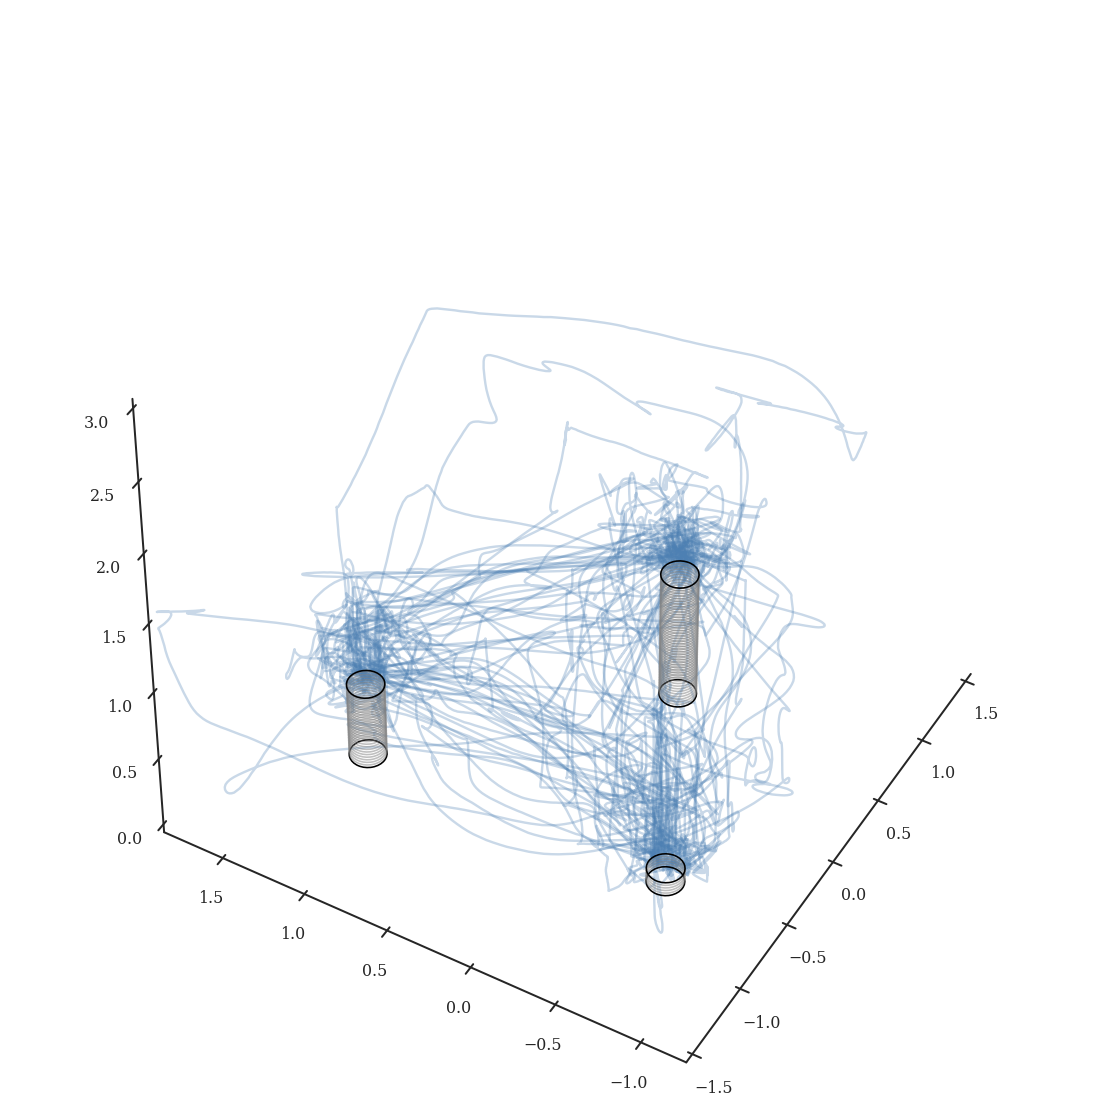

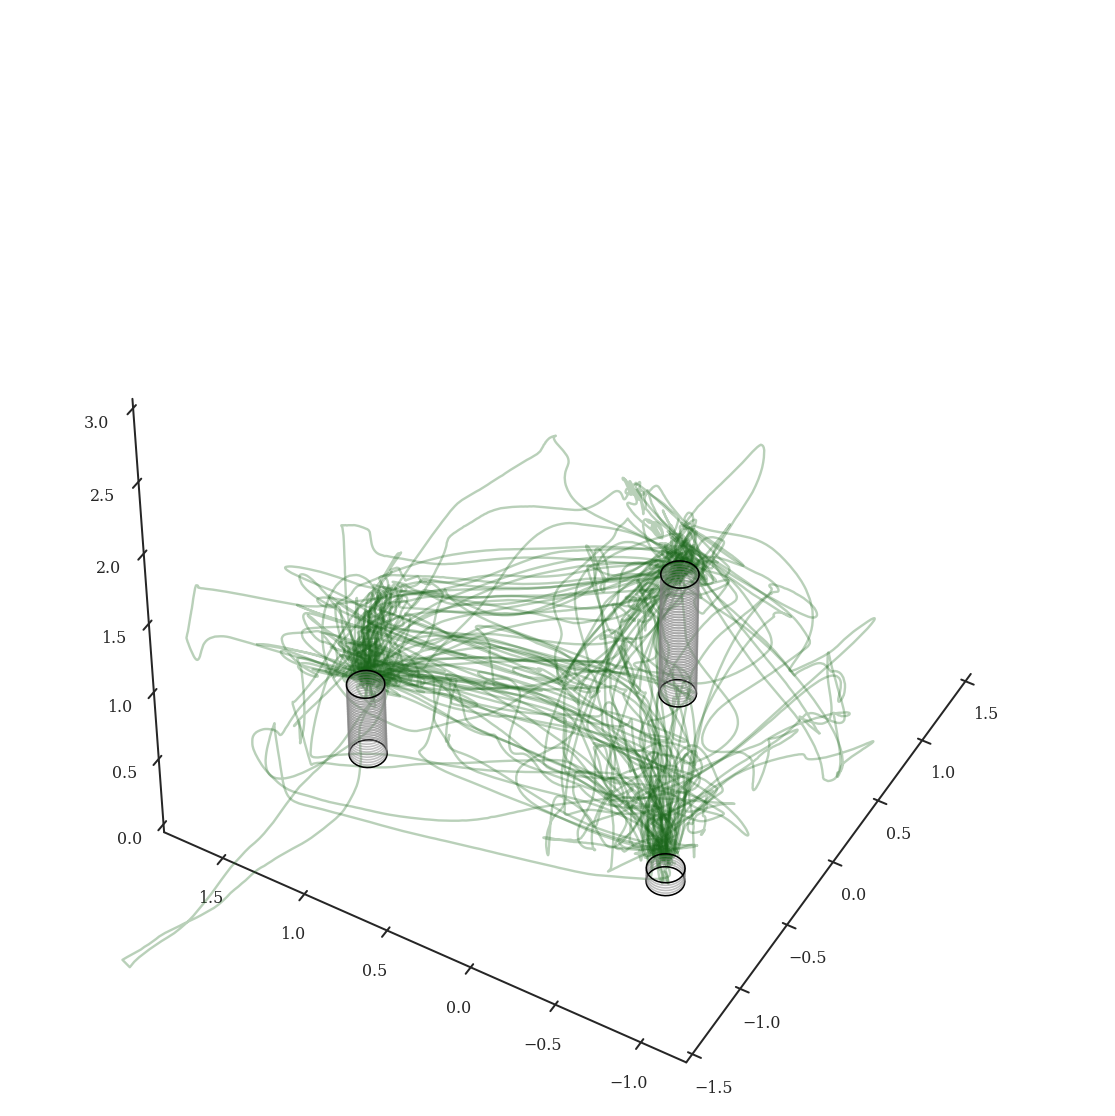

In [10]:
# All moves for all users
for interface in ['JOYSTICK','POINTING']:
    fig,ax = mkfig(moves[(moves.interface==interface)], alpha=0.3)
    ax.view_init(azim=0+180,elev=90)
    fig.savefig(f'all-{interface}-90')
    ax.view_init(azim=30+180,elev=45)
    fig.savefig(f'all-{interface}-45')
